# WGCNA

+ Author: Margaret Paiva
+ Date: 2021-12-11
+ Output: R notebook

WGCNA defines co-expression networks as undirected, weighted gene networks. The nodes of such a network correspond to gene expression profiles, and edges between genes are determined by the pairwise correlations between gene expression. It alleviates the multiple testing problem and focuses on the relationship between a few modules and the sample trait. Toward this end, it calculates the eigengene significance (correlation between sample trait and eigengene) and the corresponding p-value for each module. The module definition does not make use of a priori defined gene sets. Instead, modules are constructed from the expression data by using hierarchical clustering.

## 1. Dependencies

In [1]:
# cran packages
x <- c('dplyr',
       'data.table',
       'tidyr',   
       'tidyverse', 
       'tibble',
       'ggplot2', 
       'cluster', 
       'WGCNA')
# bioconductor packages
y <- c('GO.db')

In [2]:
# install cran packages
for (pkg in x) {
    if (!pkg %in% rownames(installed.packages())) {install.packages(pkg)}
}

In [3]:
# install bioconductor packages
if (!requireNamespace("BiocManager", quietly=TRUE))
    install.packages("BiocManager")
for (pkg in y) {
    if (!requireNamespace(pkg, quietly=TRUE)) {
        BiocManager::install(pkg)
    }
}

In [4]:
# load packages
load_lib <- function(x) {
    suppressPackageStartupMessages(library(x, character.only = TRUE))
}
invisible(lapply(c(x, y), load_lib))

In [5]:
allowWGCNAThreads()   
options(stringsAsFactors = FALSE)

Allowing multi-threading with up to 8 threads.


## 2. Request data from API
Request data from API using the files at https://github.com/Champions-Oncology/Workspaces/tree/main/1starter_data_request.

This notebook used the following options to request data:

(This notebook used [this example list of genes](https://github.com/Champions-Oncology/Workspaces/blob/main/gene_list.csv). You may define your genes of interest in a .csv file and use it in the data requesting file.)

- table="expression",
- cancer_type=["Renal cell carcinoma", "Prostate", "Adenoid cystic carcinoma", "Breast", "Thyroid", "Testicular", "Hepatocellular carcinoma", "Melanoma"],
- genes=list(genes_df['gene']),
- source = "PDX"
(For example, if you use the data_request.ipynb in Python, these are the options in the df, location = request_data() function.)

## 3. Read data

In [6]:
# change to where you saved your .csv file and file name
df  <- fread("../data/pdx_expression_gene_list_multi_cancer.csv")
df  <- as.data.frame(df)
df$gene  <- as.character(df$gene)  # each column is a list - specify data type
df$model  <- as.character(df$model)
df$tumor_type  <- as.character(df$tumor_type)
df$log.tpm  <- as.numeric(df$log.tpm)
head(df, 2)
print(dim(df))

,gene,model,model_name,log.tpm,z,fold,tumor_type
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
1,ACSM3,CTG-3501,CTG-3501,2.7411490,-0.1693172,0.8765697,Breast
2,COPZ2,CTG-3501,CTG-3501,0.7995996,-0.9946150,0.1851744,Breast


[1] 82800     7


In [7]:
# Pivot the table
log_tpm <- df %>% 
    dplyr::select(c('gene', 'model', 'log.tpm'))  %>% 
    pivot_wider(names_from = gene, values_from = log.tpm)  %>% 
    column_to_rownames('model')
log_tpm  <- log_tpm[complete.cases(log_tpm),]  # remove rows with missing values
log_tpm[1:2, 1:10]
print(dim(log_tpm))

,ACSM3,COPZ2,BZRAP1,CX3CL1,ETV1,ALDH3B1,ACPP,CHDH,CD74,FHL1
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CTG-3501,2.741149,0.7995996,2.833298,4.224392,0.9328516,1.441369,2.463359,3.7351793,2.288166,0.9457198
CTG-0718,3.214430,4.1304615,2.401043,1.547657,3.9235433,2.984612,0.000000,0.4733435,5.082362,3.4499709


[1] 207 400


## 4. Select the power

In [8]:
# Choose a set of soft-thresholding powers
powers = c(c(1:10), seq(from = 12, to = 20, by = 2))

# Call the network topology analysis function
sft = pickSoftThreshold(
  log_tpm,             # <= Input data
  powerVector = powers,
  verbose = 5
  )

pickSoftThreshold: will use block size 400.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 400 of 400
   Power SFT.R.sq  slope truncated.R.sq mean.k. median.k. max.k.
1      1   0.0276 -0.329         0.9470 67.7000  6.40e+01 122.00
2      2   0.5900 -1.140         0.9020 18.3000  1.54e+01  52.30
3      3   0.8710 -1.450         0.9270  6.3900  4.50e+00  26.90
4      4   0.2140 -2.930         0.0112  2.6500  1.57e+00  15.70
5      5   0.8950 -1.570         0.8700  1.2500  5.99e-01  10.00
6      6   0.9080 -1.520         0.8840  0.6610  2.40e-01   6.78
7      7   0.8970 -1.470         0.8670  0.3810  9.81e-02   4.82
8      8   0.2350 -2.270         0.0362  0.2370  4.39e-02   3.55
9      9   0.2350 -2.180         0.0450  0.1570  2.03e-02   2.69
10    10   0.2350 -2.060         0.0487  0.1100  9.13e-03   2.08
11    12   0.1970 -1.770        -0.0327  0.0615  1.98e-03   1.31
12    14   0.9700 -1.080         0.9850  0.0393  4.99e-04   1.00
13 

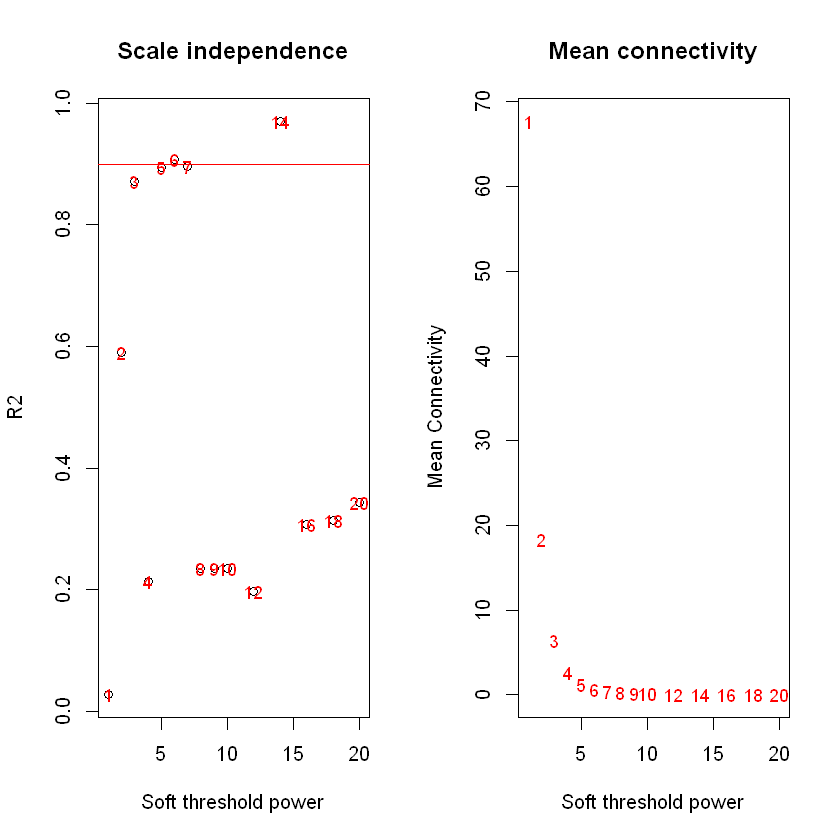

In [9]:
par(mfrow = c(1,2));
cex1 = 0.9;

plot(sft$fitIndices[, 1],
     -sign(sft$fitIndices[, 3]) * sft$fitIndices[, 2],
     xlab = "Soft threshold power",
     ylab = "R2",
     main = paste("Scale independence")
)
text(sft$fitIndices[, 1],
     -sign(sft$fitIndices[, 3]) * sft$fitIndices[, 2],
     labels = powers, cex = cex1, col = "red"
)
abline(h = 0.90, col = "red")
plot(sft$fitIndices[, 1],
     sft$fitIndices[, 5],
     xlab = "Soft threshold power",
     ylab = "Mean Connectivity",
     type = "n",
     main = paste("Mean connectivity")
)
text(sft$fitIndices[, 1],
     sft$fitIndices[, 5],
     labels = powers,
     cex = cex1, col = "red")

The network exhibits a scale-free topology if the frequency distribution $p(k)$ of the connectivity follows a power law. We use $R^2$, the square of the correlation between $log(p(k))$ and $log(k)$. There is a natural trade-off between maximizing scale-free topology model fit (scale-free fitting parameter $R^2$) and maintaining a high mean number of connections. High values of $β$ often lead to high values of $R^2$. But the higher the power $β$, the lower is the mean connectivity of the network. the mean connectivity should be high so that the network contains enough information. In the meantime, the soft threshold power $β$ should at least lead to a network satisfying scale-free topology approximately, e.g. $R^2 > 0.80$.

According to the above two plots, here we pick the soft threshold power = 6.

## 5. Create the network

In [10]:
picked_power = 6
temp_cor <- cor       
cor <- WGCNA::cor         # Force it to use WGCNA cor function (fix a namespace conflict issue)
netwk <- blockwiseModules(log_tpm,                # <= input here

                          # == Adjacency Function ==
                          power = picked_power,                # <= power here
                          networkType = "signed",

                          # == Tree and Block Options ==
                          deepSplit = 2,
                          pamRespectsDendro = F,
                          minModuleSize = 30,
                          maxBlockSize = 4000,

                          # == Module Adjustments ==
                          reassignThreshold = 0,
                          mergeCutHeight = 0.25,

                          # == Archive the run results in TOM file (saves time) == 
                          saveTOMs = T,
                          saveTOMFileBase = "ER",

                          # == Output Options
                          numericLabels = T,
                          verbose = 3)
cor <- temp_cor     # Return cor function to original namespace

 Calculating module eigengenes block-wise from all genes
   Flagging genes and samples with too many missing values...
    ..step 1
 ..Working on block 1 .
    TOM calculation: adjacency..
    ..will not use multithreading.
     Fraction of slow calculations: 0.000000
    ..connectivity..
    ..matrix multiplication (system BLAS)..
    ..normalization..
    ..done.
   ..saving TOM for block 1 into file ER-block.1.RData
 ....clustering..
 ....detecting modules..
 ....calculating module eigengenes..
 ....checking kME in modules..
     ..removing 59 genes from module 1 because their KME is too low.
     ..removing 29 genes from module 2 because their KME is too low.
     ..removing 6 genes from module 3 because their KME is too low.
 ..merging modules that are too close..
     mergeCloseModules: Merging modules whose distance is less than 0.25
       Calculating new MEs...


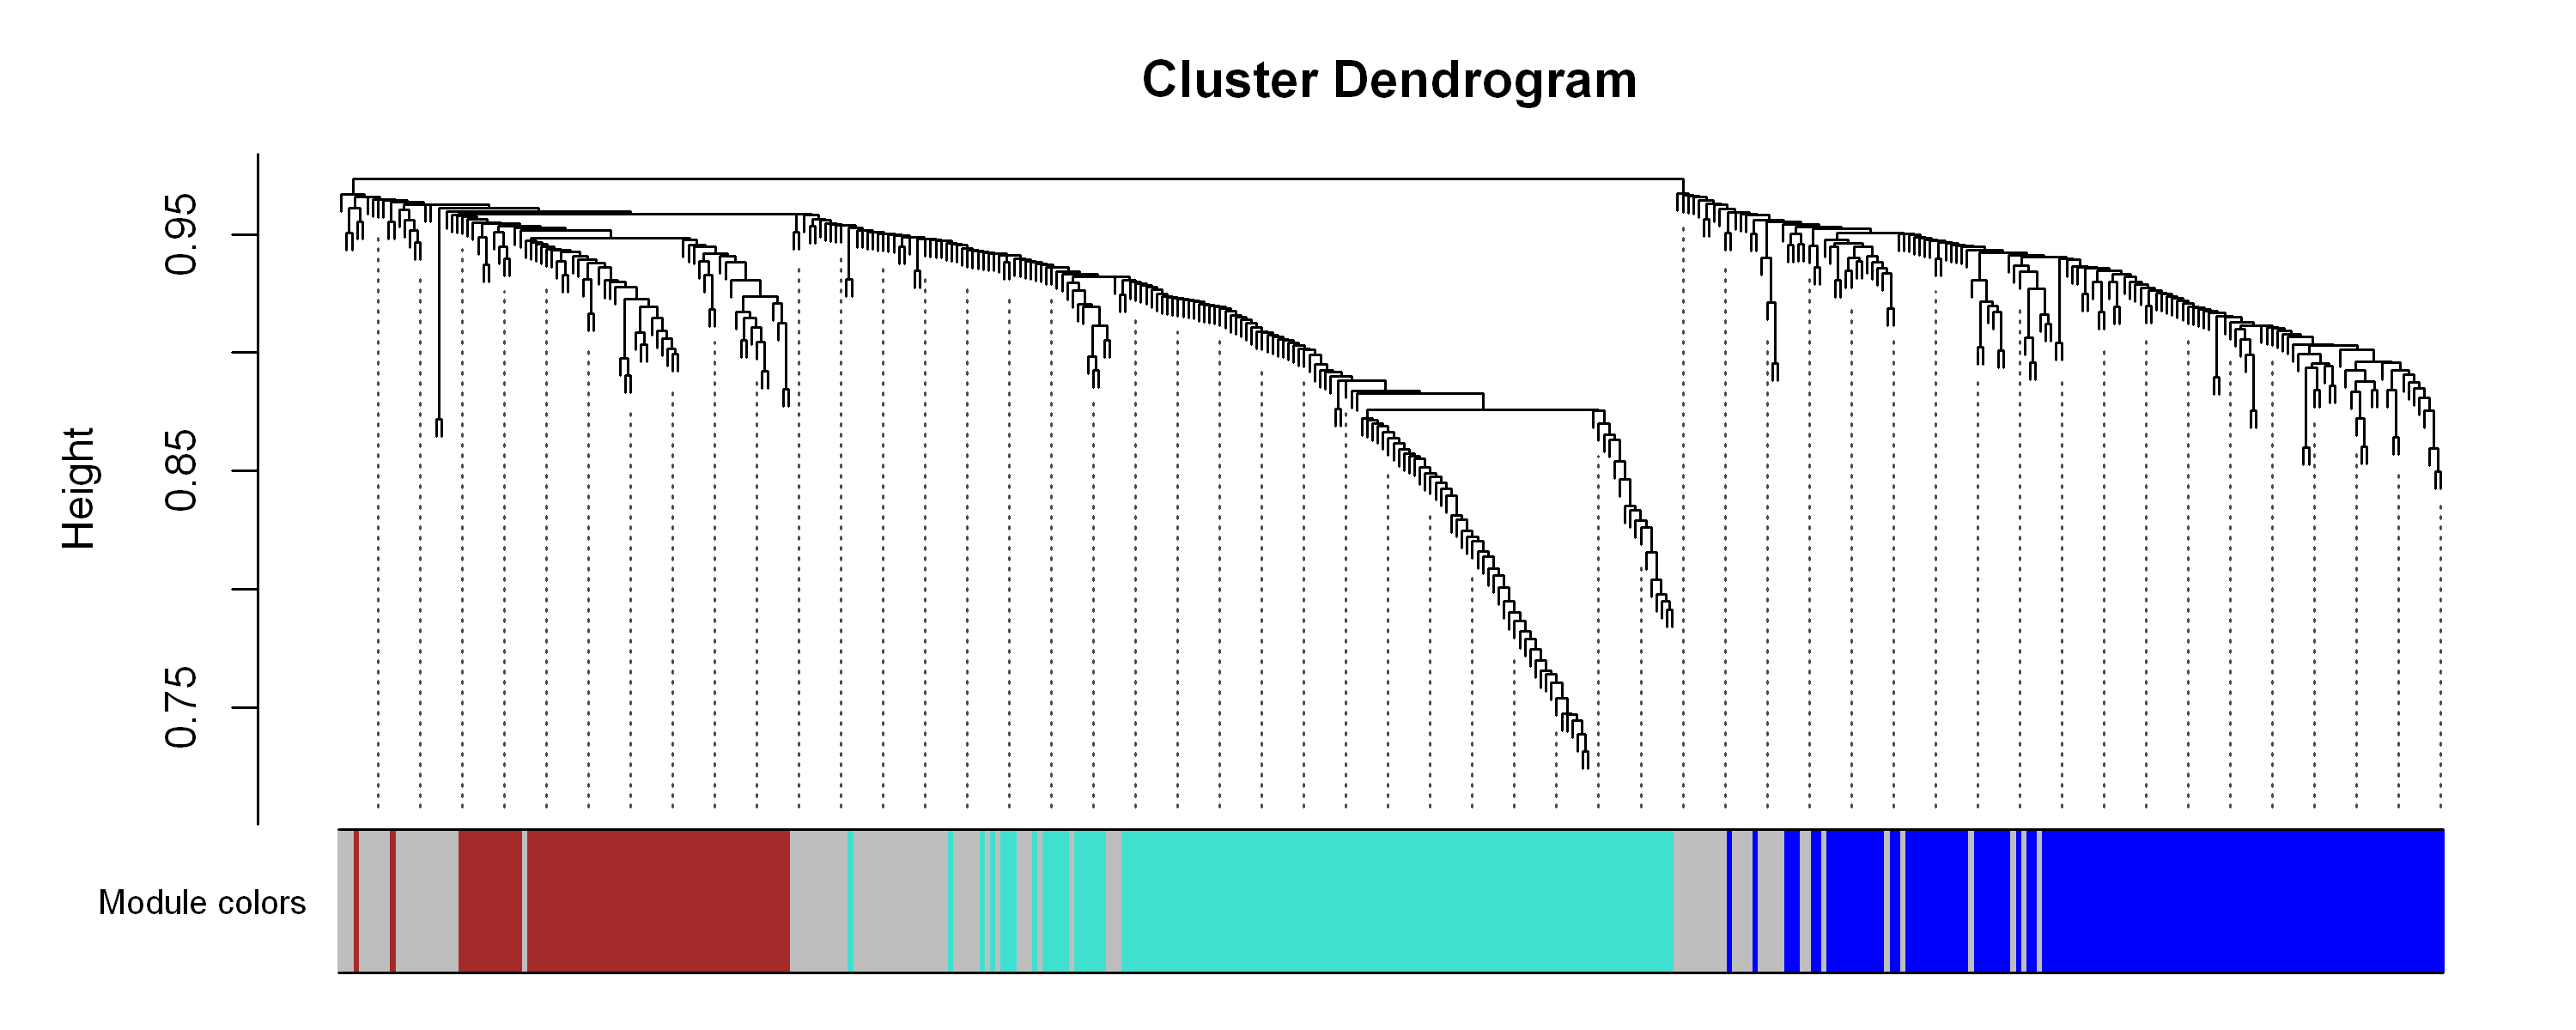

In [11]:
# Convert labels to colors for plotting
mergedColors = labels2colors(netwk$colors)
# Plot the dendrogram and the module colors underneath
options(repr.plot.width=10, repr.plot.height=4, repr.plot.res=300)
plotDendroAndColors(
  netwk$dendrograms[[1]],
  mergedColors[netwk$blockGenes[[1]]],
  "Module colors",
  dendroLabels = FALSE,
  hang = 0.03,
  addGuide = TRUE,
  guideHang = 0.05 )

## 6. Relate the modules

In [12]:
module_df <- data.frame(
  gene_id = names(netwk$colors),
  colors = labels2colors(netwk$colors)
)

In [13]:
head(module_df)

,gene_id,colors
,<chr>,<chr>
1,ACSM3,grey
2,COPZ2,blue
3,BZRAP1,turquoise
4,CX3CL1,blue
5,ETV1,blue
6,ALDH3B1,blue


In [14]:
# Get Module Eigengenes per cluster
MEs0 <- moduleEigengenes(log_tpm, mergedColors)$eigengenes

# Reorder modules so similar modules are next to each other
MEs0 <- orderMEs(MEs0)
module_order <- names(MEs0) %>% gsub("ME","", .)

# Add model names
MEs0$model = row.names(MEs0)

head(MEs0, 2)

,MEblue,MEbrown,MEturquoise,MEgrey,model
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
CTG-3501,0.02577112,-0.03303260,0.01635805,-0.11555395,CTG-3501
CTG-0718,0.08676584,-0.07821476,-0.09837409,0.03777795,CTG-0718


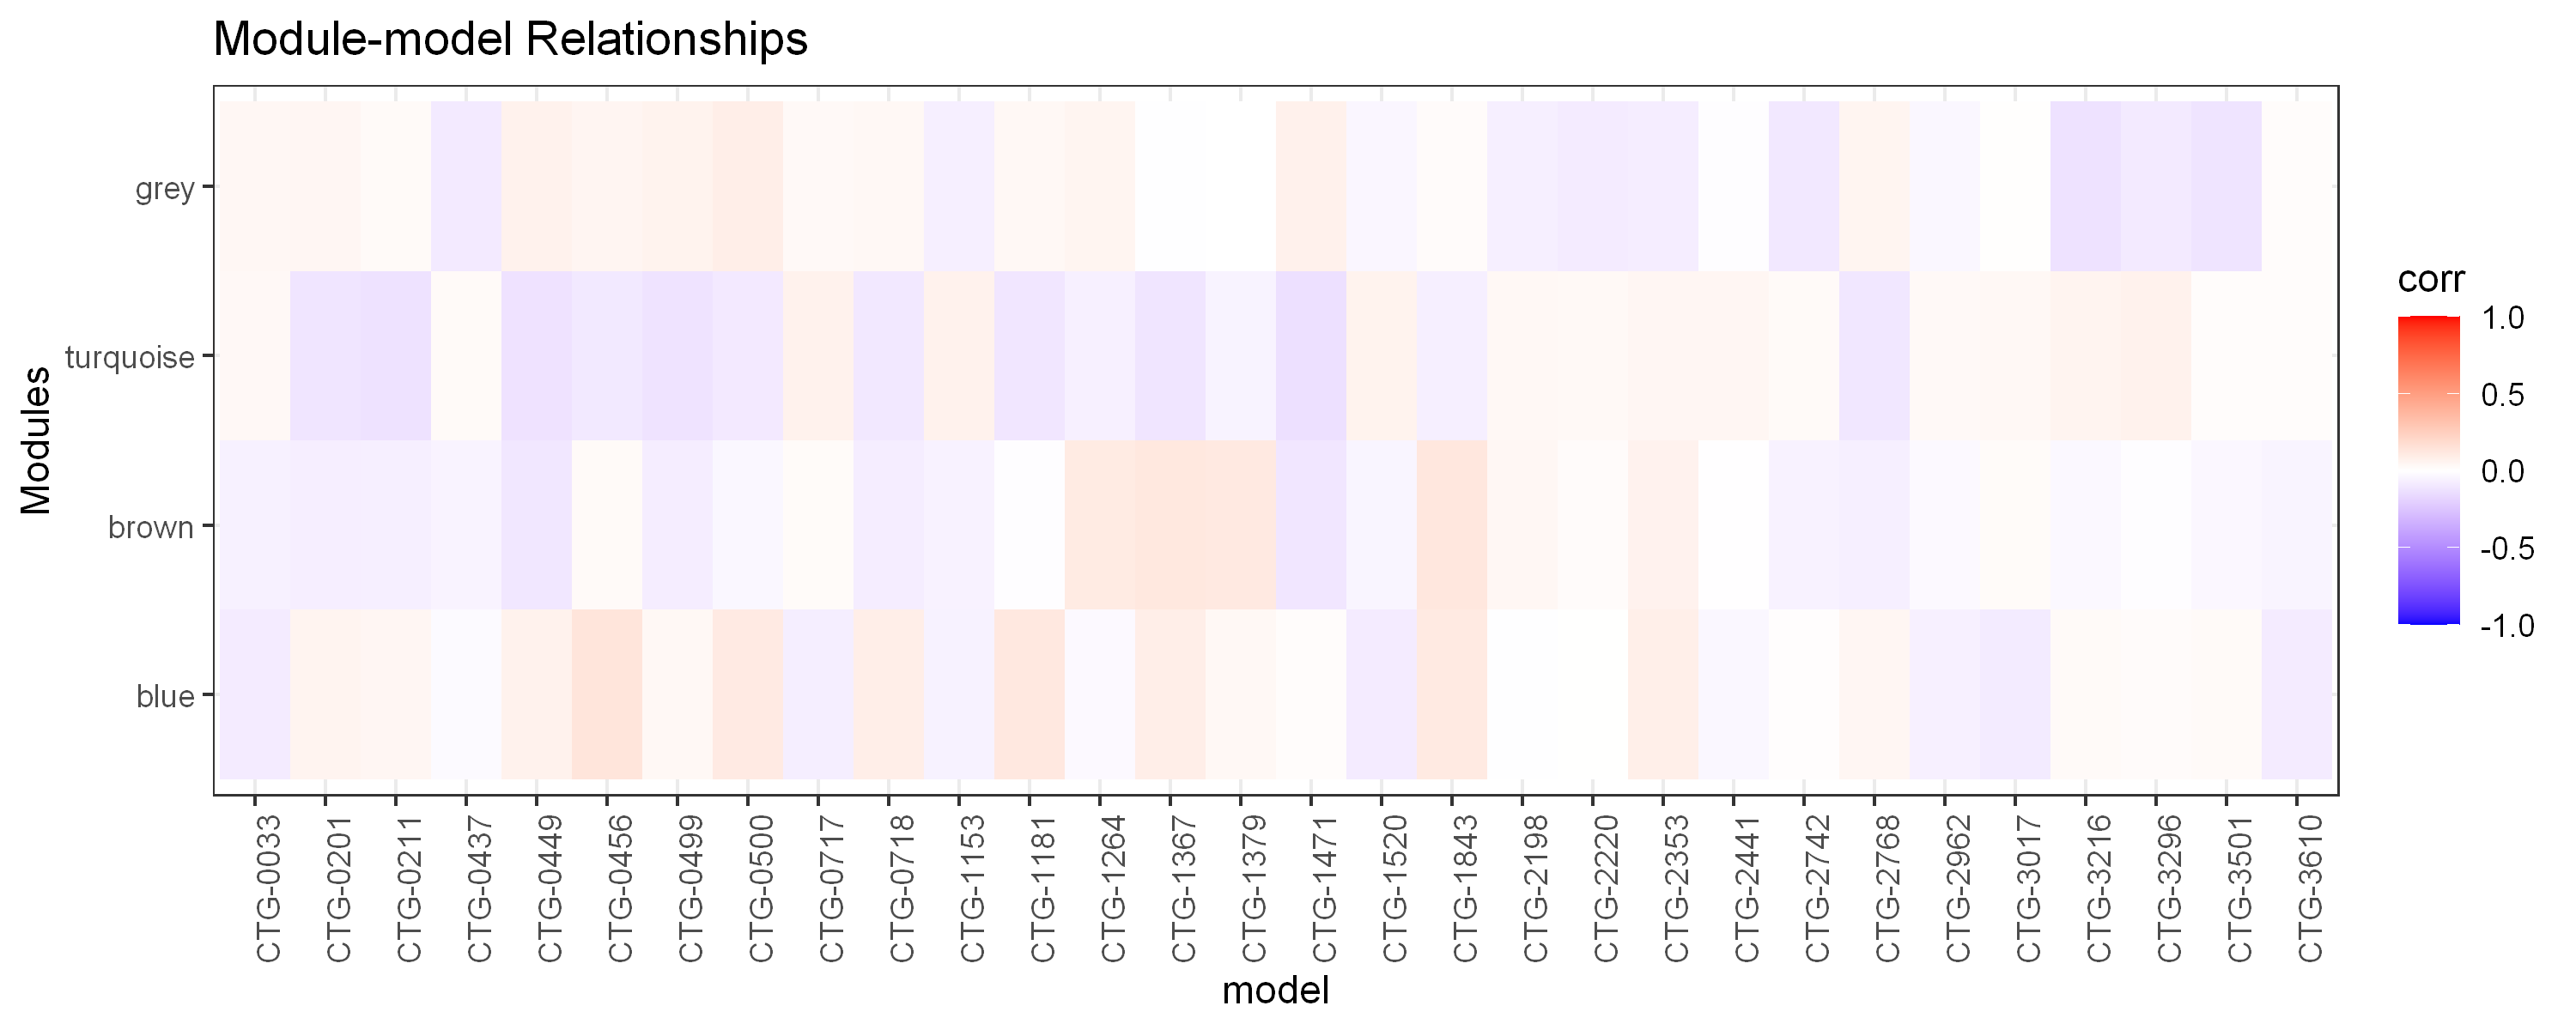

In [15]:
# tidy & plot data
mME = MEs0[1: 30,] %>%  # choose the first numbers of models here - you may select models of interest
  pivot_longer(-model) %>%
  mutate(
    name = gsub("ME", "", name),
    name = factor(name, levels = module_order)
  )

mME %>% ggplot(., aes(x=model, y=name, fill=value)) +
  geom_tile() +
  theme_bw() +
  scale_fill_gradient2(
    low = "blue",
    high = "red",
    mid = "white",
    midpoint = 0,
    limit = c(-1,1)) +
  theme(axis.text.x = element_text(angle=90)) +
  labs(title = "Module-model Relationships", y = "Modules", fill="corr")